# Neural Networks for Data Science Applications
## Final Homework: Putting everything together

**Name**: *Alexandru Melnic*

**Matricola**: *1692625*

Send the completed notebook before 15-01-2021 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_2_\<id\>".

**Overview**: The homework is composed of four parts: (i) select a dataset; (ii) implement a custom component (ONLY if you did not submit the first homework); (iii) implement a neural network and train it on the dataset; (iv) perform a post-training operation on the method (interpretation / robustness / fairness).

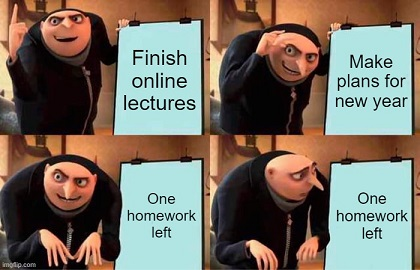

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import os
from time import time
import matplotlib.pyplot as plt

BATCH_SIZE = 64

**Important - before starting**: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*.

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts)... The task can be either classification or a more complex task (e.g., segmentation, sequence prediction, ...). *For tasks beyond classification, check carefully that the final exercise is viable before starting your implementation.*

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark, so you can select a complexity that you believe adequate to your skills.

**DESCRIPTION OF THE CODE**: The objective of the model is to generate cat faces with a GAN. The dataset is downloaded from kaggle and it is composed by different cat faces of different colors and also different lightings. To simplify the problem the images are loaded as black and white. 

In [ ]:
# Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

files.upload() # import the json file provided by kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models

!unzip -q /content/cats-faces-64x64-for-generative-models.zip

Saving kaggle.json to kaggle.json
 84% 81.0M/96.0M [00:00<00:00, 69.5MB/s]
100% 96.0M/96.0M [00:00<00:00, 104MB/s] 


Found 15747 files belonging to 1 classes.


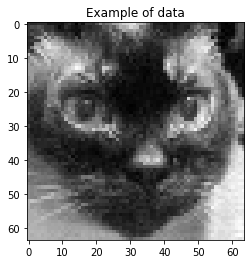

In [ ]:
# create a dataset tf object from data in the folder
data = tf.keras.preprocessing.image_dataset_from_directory('/content/cats',
                                                           color_mode='grayscale', batch_size=BATCH_SIZE, 
                                                           image_size = (64, 64), label_mode=None,
                                                           shuffle=True)
# example of data
x = next(iter(data))[0]
x = tf.reshape(x, (64,64))
x = tf.cast(x, 'float32') / 255.0
plt.imshow(x, cmap='gray')
plt.title('Example of data')
plt.show()

In [ ]:
# rescale image between -1 and 1. The generator output
# will have a tanh as activation function. It is used in the tf
# guide and also suggested in the DCGAN paper.

def img_process(img):
    img = (tf.cast(img, tf.float32) - 127.5 ) / 127.5
    return img

val_data = data.take(5).map(img_process) # take the first 5 batches as validation data
train_data = data.skip(5).map(img_process).cache().prefetch(tf.data.experimental.AUTOTUNE)

### Exercise 1: Implement a custom object (5 points)

**This exercise is required only for students that have not submitted the mid-term homework, or for students who want to raise their mid-term mark (mark <= 3/5). For a mark of 4/5, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 2 and 3, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*. 

[Papers With Code](https://paperswithcode.com/methods) is a repository of state-of-the-art tasks and components for deep networks, including:

1. [Optimizers](https://paperswithcode.com/methods/category/optimization)
2. [Residual components](https://paperswithcode.com/methods/category/skip-connection-blocks)
3. [Attention mechanisms](https://paperswithcode.com/methods/category/attention-mechanisms)
4. [Regularizers](https://paperswithcode.com/methods/category/regularization)
5. [Activation functions](https://paperswithcode.com/methods/category/activation-functions)
6. [Normalization blocks](https://paperswithcode.com/methods/category/normalization)
7. [Loss functions](https://paperswithcode.com/methods/category/loss-functions)
8. [Variants of feedforward networks](https://paperswithcode.com/methods/category/feedforward-networks)

Select a component in the categories above **not covered during the course**, and provide a working implementation in **TensorFlow 2.x**. A re-implementation is preferable; if you use an open implementation, state it clearly below. If you re-use parts of an open implementation, also state it clearly below.

**DESCRIPTION OF THE CODE**: *provide a small description of the method you have implemented, with all necessary links. If needed, explain why it is useful for the task you have selected (e.g., if implementing a different loss function).*

In [ ]:
# Insert your custom component here
class MyCustomDropout(tf.keras.Layer):
  # ...

In [ ]:
# Optionally, briefly show how the component can be used

### Exercise 2: Train on your data (5 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. If you did Exercise 1, **include your custom component here**. Otherwise, you are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

**DESCRIPTION OF THE CODE**: The GAN is composed by two networks: the generator and the discriminator. The role of the former is to transform points sampled from a gaussian vector (latent vector) of 100 components (LATENT_DIM) to 64x64 pixel images, i.e. cat faces. The role of the discriminator is the one to classify wether the proposed image is coming from the real dataset or if it is generated. The two networks are trained in a minimax game, where the discriminator wants to distinguish as best as it can the real cats from the fake ones (just minimize a cross entropy) and the generator wants to fool as best as it can the discriminator (maximize the discriminator loss function).  

For the overall idea: https://arxiv.org/abs/1701.00160 \\
Tensorflow tutorial on GAN for the blocks and overall idea: https://www.tensorflow.org/tutorials/generative/dcgan \\
DCGAN for Generator architecture :https://arxiv.org/pdf/1511.06434.pdf \\
For the least square loss: https://arxiv.org/pdf/1611.04076.pdf \\

The architectures are inspired both from the tensorflow example on the DCGAN and the papers listed above. In this case, after some trials, the cross entropy seemed to work better than the LS loss. 

In [ ]:
class GeneratorBlock(layers.Layer):

    '''
    Fundamental block of the generator. 
    '''
    def __init__(self, num_filters):
        super(GeneratorBlock, self).__init__()
        self.conv_layer = layers.Conv2DTranspose(num_filters, (5, 5), 
                                                 strides=(2, 2), 
                                                 padding='same', use_bias=False)
        self.bn = layers.BatchNormalization()
        self.activation_fun = layers.LeakyReLU()

    def call(self, inputs):
        x = self.conv_layer(inputs)
        x = self.bn(x)
        return self.activation_fun(x)

class DiscriminatorBlock(layers.Layer):

    '''
    Fundamental block of the discriminator. 
    '''

    def __init__(self, num_filters):
        super(DiscriminatorBlock, self).__init__()
        self.conv_layer = layers.Conv2D(num_filters, 5, 
                                        strides = (2,2),  
                                        padding='same')
        
        # the batch norm is not used in the tf guide but again
        # suggested in the DCGAN paper.
        self.bn = layers.BatchNormalization()
        self.dropout_layer = layers.Dropout(0.3)
        self.activation_fun = layers.LeakyReLU()
        

    def call(self, inputs):
        x = self.conv_layer(inputs)
        x = self.bn(x)
        x = self.dropout_layer(x)
        return self.activation_fun(x)
        

class Generator(tf.keras.Model):
    '''
        Generator model. The architecture is the one used by the DCGAN:
        essentialy they are all convtranspose/batch norm/leaky relu blocks.

    '''
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        self.dense_layer = layers.Dense(4*4*1024, activation='relu',
                                        use_bias=False, input_shape=(1,latent_dim))
        self.bn_layer = layers.BatchNormalization()
        self.activation_layer = layers.LeakyReLU()
        self.reshape_layer = layers.Reshape((4,4,1024))
        self.block_1 = GeneratorBlock(512)
        self.block_2 = GeneratorBlock(256)
        self.block_3 = GeneratorBlock(128)
        self.last_conv_layer = layers.Conv2DTranspose(1, (5, 5), 
                                                      strides=(2, 2), 
                                                      padding='same', 
                                                      use_bias=False, 
                                                      activation='tanh')
        
    def call(self, inputs):
        
        x = self.dense_layer(inputs)
        x = self.bn_layer(x)
        x = self.activation_layer(x)
        x = self.reshape_layer(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.last_conv_layer(x)
        return x

class Discriminator(tf.keras.Model):
    '''
        Discriminator model: this is just a normal classifier, it uses
        mainly conv/batch norm/droput/leaky rely blocks.
    '''
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block_1 = DiscriminatorBlock(64)
        self.block_2 = DiscriminatorBlock(128)
        self.block_3 = DiscriminatorBlock(256)
        self.flatten_layer = layers.Flatten()
        self.dense_layer = layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.flatten_layer(x)
        return self.dense_layer(x)



'''
At each training step the model is fed with both real and generated images. 
The loss function for the discriminator is a standard cross entropy, where 1
stands for real image and 0 for fake. 

The generator wants to increase the loss of the discriminator, for this reason
it is trained by maximizing the error of it: instead of allowing it to
classify fake images as 0s it wants the discriminator to classify fake images as 
1s.

'''

def discriminator_loss_ce (real_output, fake_output):
    real_loss_part = ce_loss(tf.ones_like(real_output), real_output)
    fake_loss_part = ce_loss(tf.zeros_like(fake_output), fake_output)
    return real_loss_part + fake_loss_part

def generator_loss_ce (fake_output):
    return ce_loss(tf.ones_like(fake_output), fake_output)

def discriminator_loss_ls (real_output, fake_output):
    real_loss_part = 0.5*ls_loss(tf.ones_like(real_output), real_output)
    fake_loss_part = 0.5*ls_loss(tf.zeros_like(fake_output), fake_output)
    return real_loss_part + fake_loss_part

def generator_loss_ls(fake_output):
    return ls_loss(tf.ones_like(fake_output), fake_output)

Instantiate models, losses and optimizers.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

LATENT_DIM = 100
generator = Generator(LATENT_DIM)
discriminator = Discriminator()
ce_loss = tf.keras.losses.BinaryCrossentropy()  
ls_loss = tf.keras.losses.MeanSquaredError()    

In [ ]:
#@title Train step
@tf.function
def train_step(real_images):

    '''
    Classical training step but performed on two models instead of only one.
    
    '''
    
    noise = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # first the fake outputs are generated
        generated_images = generator(noise, training=True)
    
        # the discrminator computes the scores for the real cats
        # and fake cats
        real_output = discriminator(real_images,training=True)
        fake_output = discriminator(generated_images, training=True)
    
        # computation of the losses based on the previous outputs.
        gen_loss = generator_loss_ce(fake_output)
        disc_loss = discriminator_loss_ce(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def save_images():
    '''
    Generate figure plot them and save them.
    '''
    plt.figure(figsize = (10,10))
    for i in range(len(generated_img)):
        img = tf.reshape(generated_img[i], (64,64))
        plt.subplot(3,3,i+1)
        plt.imshow(img, cmap='gray')
        plt.savefig(f'/content/cats_epoch_{epoch + 1}.png')

In [ ]:
# list to save the losses of the two networks and accuracy of discriminator
disc_loss = []
gen_loss = []
disc_val_acc = []

In [ ]:
NUM_EPOCHS = 400

for epoch in range(NUM_EPOCHS):
    start_time = time()
    print('Epoch: ',epoch+1)
    
    for batch in train_data:
        G_loss, D_loss = train_step(batch)
        disc_loss.append(D_loss)
        gen_loss.append(G_loss)

    acc = tf.keras.metrics.BinaryAccuracy()
    # check the accuracy of the discriminator on the val set
    for batch in val_data:
        
        # generate fake data and take real data from the val set
        # to compute the discriminator accuracy
        noise = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))
        generated_cats = generator(noise)
        pred_on_generated_cats = discriminator(generated_cats)
        pred_on_real_cats = discriminator(batch)
        batch_val_acc = acc(tf.zeros_like(pred_on_generated_cats), pred_on_generated_cats)
        batch_val_acc += acc(tf.ones_like(pred_on_real_cats), pred_on_real_cats)
        disc_val_acc.append(batch_val_acc/2)
    
    '''
    # every 50 epochs save plot of examples
    if (epoch + 1) % 50 == 0:
        noise = tf.random.normal(shape=(9, LATENT_DIM))
        generated_img = generator(noise)
        save_images()
    '''
    
    print('Gen loss: ', G_loss.numpy(), 'Disc loss: ', D_loss.numpy(),
          'Discriminator val accuracy: ' , disc_val_acc[-1].numpy(),
          'Epoch time: ',time() - start_time ,'\n')

Save the model weights

In [ ]:
generator.save_weights('/content/drive/MyDrive/NN/kaggle_cats/checkpoints/generator_weights')
discriminator.save_weights('/content/drive/MyDrive/NN/kaggle_cats/checkpoints/discriminator_weights')

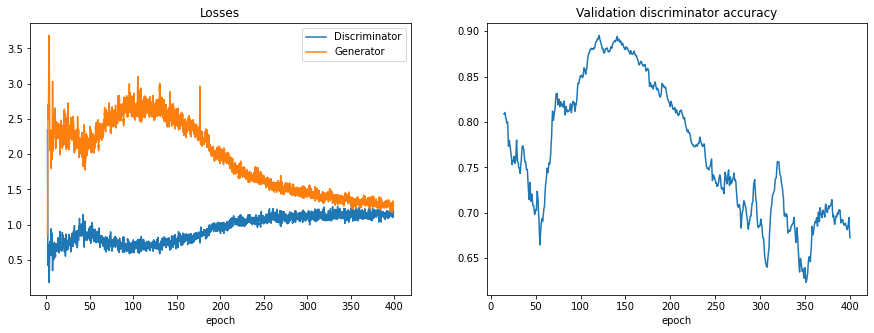

In [ ]:
#@title Plot loss functions and metrics
import pandas as pd
import numpy as np

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(1, epoch, len(disc_loss)),pd.Series(disc_loss).rolling(100).mean() ,label='Discriminator')
plt.plot(np.linspace(1,epoch,len(disc_loss)),pd.Series(gen_loss).rolling(100).mean(), label='Generator')
plt.title('Losses')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(1+np.arange(0,len(disc_val_acc))/5, pd.Series(disc_val_acc).rolling(70).mean())
plt.title('Validation discriminator accuracy')
plt.xlabel('epoch')
plt.show()

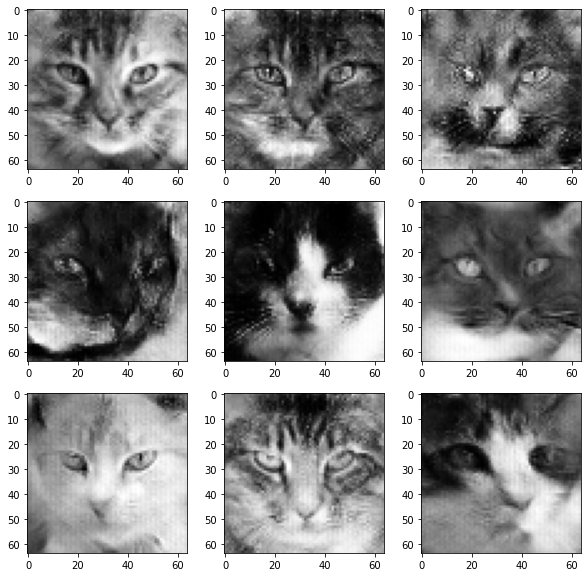

In [ ]:
#@title Generate examples
noise = tf.random.normal(shape=(9, LATENT_DIM))
generated_img = generator(noise)
plt.figure(figsize = (10,10))
for i in range(len(generated_img)):
    img = tf.reshape(generated_img[i], (64,64))
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')

From the examples it is possible for sure to understand what we are talking about. Nevertheless the generator has some difficulties at this point, specially in defining the borders of the faces and almost in every case the mouths.

### Exercise 3 (5 points)

Training a model is only the beginning! Select **one of the three** paths below, and follow the instructions.

1. **Interpreting your model**: interpretability is critical in many applications. Good libraries for obtaining interpetations from your model are [tf-explain](https://github.com/sicara/tf-explain), the original [LIME implementation](https://github.com/marcotcr/lime), and IBM [AIX360 Toolbox](https://github.com/Trusted-AI/AIX360). For this path, select an interpretability method, *read carefully the original paper*, and test it on one of your input examples. You can use one of the basic methods seen in the course, or a more advanced variant (e.g., Gradients*Input, Integrated Gradients, ...).

2. **Attacking your model**: there are a number of libraries for crafting an adversarial attack. Possible alternatives are [CleverHans](https://github.com/tensorflow/cleverhans), [Foolbox](https://github.com/bethgelab/foolbox), or the [Adversarial Robustness Toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox). Select one white-box adversarial attack, *read carefully the original paper*, and create an adversarial attack on your network. You can use FGSM as seen in the course, or a more advanced method (e.g., JSMA, ...).

3. **Fairness**: finally, you might want to evaluate whether your model is fair. Good libraries for this are [FAT Forensics](https://fat-forensics.org/) or IBM [AIF360 Toolbox](https://github.com/Trusted-AI/AIF360). For this exercise, select a fairness metric, and evaluate the group fairness on your dataset. Then, apply a post-processing to enforce the fairness, and evaluate the eventual variation in accuracy.

**DESCRIPTION OF THE CODE**: The idea is to take two points in the latent space, get points laying on the line passing through them and check how the generate images are changing.

Load the models 

In [ ]:
generator = Generator(LATENT_DIM)
discriminator = Discriminator()

generator.load_weights('/content/drive/MyDrive/NN/kaggle_cats/checkpoints/generator_weights')
discriminator.load_weights('/content/drive/MyDrive/NN/kaggle_cats/checkpoints/discriminator_weights')

Selected vectors in the latent space to interpolate. They were chosen by randomly generating some examples.

In [ ]:
#@title Selected vectors in the latent space corresponding to a white cat looking right and a black cat looking left.
cat1 = tf.constant([-0.17740843,  0.08912309,  1.1401845 ,  0.9148962 , -1.313496  ,
        0.69154495,  1.5183657 , -1.7412683 , -0.54559815, -0.5540706 ,
        1.446265  ,  1.5281537 , -0.10796185, -0.74634284,  0.8515429 ,
       -0.8789672 ,  1.6464249 ,  1.2686989 , -0.09530174,  0.21553688,
        0.58307713,  0.38708347, -0.18471618, -0.07565154, -2.8694966 ,
       -1.583803  , -0.24976107, -0.12797579,  0.34691104, -1.55806   ,
        0.92757094, -2.39751   , -0.22394899,  1.6700127 , -0.30160123,
        0.12767996, -0.52241343, -0.17102902,  0.45014554,  0.6285399 ,
        1.2683328 , -1.5832334 ,  1.7784475 , -0.2711283 ,  1.564635  ,
       -0.25279087, -0.43217134,  1.2039298 , -0.6629081 ,  1.3524389 ,
       -3.0165136 , -1.8507712 , -0.66063726, -0.26218638, -0.87420654,
       -0.87300116, -1.3636528 , -0.51627845, -0.03463612, -0.9155067 ,
       -0.7784151 ,  0.5627586 ,  1.4681712 ,  0.38082793, -0.70515996,
        1.5844686 , -1.0008619 , -0.40677103,  1.4332097 ,  1.323452  ,
       -0.82224375,  0.47196266,  1.3148116 , -0.29565215,  0.5905261 ,
       -0.33128864, -0.03547808, -0.69932944,  0.06480718, -0.01094667,
        1.4720256 , -0.69676554, -0.02677707,  0.5318988 , -0.5069536 ,
       -0.43269074, -0.92503524,  0.7743597 , -0.68822455, -0.32298145,
        0.20432138,  0.08251042, -1.4699367 ,  0.6353375 ,  1.3399564 ,
        0.32165918, -1.6062267 , -0.7773565 ,  0.9143053 ,  0.8811516 ])

cat2 = tf.constant([ 0.4076462 , -0.2832908 ,  0.6198151 ,  0.8530805 , -0.46081057,
       -1.0550375 , -0.51851106, -0.14448403,  0.50843567,  0.04215148,
       -1.6011803 , -0.4252573 , -0.39259252, -0.7662172 , -0.58033085,
        1.9088099 ,  0.26035246, -1.2163086 ,  0.77307093, -1.6524503 ,
        1.3240898 ,  0.12626705,  0.82272154, -0.13048112, -0.97060364,
        0.76479125, -2.0912888 ,  0.6484452 , -0.3958135 , -0.65690225,
        1.1852556 , -0.74257183, -1.3548869 , -0.09662399, -2.2380054 ,
        0.52673   ,  0.01448561, -0.7649793 , -1.2040839 , -0.5971248 ,
       -0.8589733 , -0.18016496,  0.41384843, -0.37310424,  1.9833204 ,
        0.20528206, -0.36629447,  0.9518965 ,  0.22162844, -0.5633558 ,
       -0.40214843, -1.0996983 , -1.0345176 ,  0.38940683,  2.106988  ,
       -1.5333935 ,  1.6944133 , -0.01780532,  0.5268966 ,  1.8883456 ,
       -0.86363727,  1.4099073 ,  0.8495461 ,  0.23264767,  0.13516764,
       -1.7248294 ,  0.90219784,  0.5921534 ,  0.7550128 , -1.5458649 ,
       -0.27121523, -1.2840105 ,  0.43814752, -1.1600095 ,  1.111785  ,
       -0.25175726, -0.12107333,  0.41034985,  0.3978224 ,  0.58487236,
       -2.2719297 ,  0.15662767,  0.42346027,  0.34967571,  0.35090327,
       -0.12128888,  0.52742803,  0.31700408,  0.9585841 ,  1.9507375 ,
       -0.8729107 ,  0.75156146, -1.0095477 ,  0.5836497 ,  1.154539  ,
       -1.6519662 ,  0.5989851 , -1.0350876 ,  0.42419094, -0.03407721])

In [ ]:
#@title Selected vectors in the latent space corresponding to a cat with closed eyes and one with opened.
cat_eyes_closed  = tf.constant([-0.07368708, -0.25326747,  0.7985607 ,  0.88754094, -1.143561  ,
       -1.844603  ,  1.7560216 , -0.6715358 ,  0.39333862, -0.6849478 ,
       -1.8788897 , -0.29186895,  0.8511571 ,  0.3361193 ,  0.93879205,
        0.1920714 , -1.0345285 , -0.11024414, -0.85935044, -0.7674387 ,
        0.25840107,  0.35283792,  0.9548911 , -1.3198847 , -0.82762736,
        0.26743248,  0.61135983, -1.7524728 ,  0.27190086, -1.1626282 ,
        0.23638341, -0.66468304, -1.9350421 , -1.4769521 ,  0.8472148 ,
        0.60519755,  0.33309793, -0.316973  , -0.7084508 ,  0.17777526,
        0.02002967,  0.25030977, -0.52374184,  0.7290298 , -0.22079162,
       -0.47578448,  0.2037304 , -2.3171663 , -0.9359366 ,  0.5792695 ,
       -0.05373511,  1.3705206 ,  0.6832445 ,  1.6292179 , -0.793389  ,
       -1.4546683 ,  0.5322527 , -1.7770752 ,  1.4431026 , -0.2708448 ,
        0.40881985, -1.2929443 , -0.56474274, -0.98365927,  0.00370409,
        1.0298353 ,  0.04322561, -1.4876386 , -0.3412536 ,  0.03290643,
        1.2302364 , -0.04249736,  1.515055  , -0.35317323,  0.8437878 ,
       -0.30235916, -1.592662  ,  1.3941736 ,  0.82830524, -1.0264208 ,
        0.0992944 ,  1.523056  ,  0.30050072,  0.2825967 ,  0.11128677,
        0.3163886 , -0.5870805 ,  0.67918503, -0.20140819,  0.2548463 ,
        1.0626187 ,  0.309711  , -1.4969633 , -0.2617129 , -1.0683097 ,
        0.094101  , -0.4917116 , -0.25618115, -0.51100093, -0.34516105])
cat_eyes_opened = tf.constant([ 0.82420325,  0.20956141, -1.9731187 ,  0.64186585, -1.5567558 ,
        0.13898073,  0.08715522,  0.73326683,  1.5130575 ,  0.1812667 ,
       -0.7555652 ,  0.78283   ,  1.1221348 ,  0.87081575, -0.22761478,
       -1.4715632 , -0.13967036,  0.0808164 ,  0.6842367 ,  2.6418    ,
       -0.12138037, -1.6925272 , -0.26266572, -0.5618455 ,  0.01160639,
       -0.57302266,  0.1200606 ,  0.5929748 ,  1.58291   ,  0.05479051,
       -0.85123944, -0.10175815,  0.20019038, -0.00726864,  1.2494701 ,
        0.01049882, -1.1523522 ,  0.17202991,  0.20065954,  0.51152104,
       -0.6486399 , -0.01656142, -0.83697295, -1.014855  ,  0.1217711 ,
       -0.01759638,  1.1321292 ,  0.9563703 , -0.28740832, -0.87450093,
       -0.2433744 ,  1.1634305 , -0.67306215,  0.1980127 , -0.78564113,
       -1.2395473 ,  0.352604  , -0.5482469 , -0.5131408 ,  0.5843215 ,
       -1.2138444 , -0.52884036, -0.43849742, -0.79938805,  1.1073942 ,
       -1.1990156 ,  0.58453757, -0.36308506, -0.23878591,  0.71975636,
       -0.6596436 ,  1.2414976 , -1.1721092 , -0.21070504, -0.01846556,
        1.5422895 , -0.62017137,  1.1469765 ,  1.716935  ,  0.8715935 ,
        0.7041822 ,  0.24397355, -0.9347575 ,  0.9110908 ,  0.34874997,
        0.8159726 ,  0.20484342, -1.5895907 , -0.3702761 ,  1.0817624 ,
       -0.3580536 ,  0.66840726, -1.0245615 ,  1.5343194 , -1.2682683 ,
        0.34912395,  1.8942255 , -0.2761898 ,  1.5441539 ,  0.4613072 ])

Functions that get points on the line passing through the two cat points in the latent space.

In [ ]:
def line_black_white_cats(t, cat1, cat2):

    ''' 
    Function that takes points on a line passing between the vectors cat1 and cat2.
    '''
    return t*cat1 + (1-t)*cat2

def generate_line_of_cats(cat1, cat2, segment_range):

    '''
    Get the points on the line between cat1 and cat2 and generate actual images.
    At the end the inverse list is added to the original one to make a better
    animation.
    
    '''
    cats_on_line = []
    for t in tf.range(segment_range[0],segment_range[1],0.05): # -0.4, 0.8 // 0.4, 1.4, 0.05
        temp = generator(tf.reshape(line_black_white_cats(t, cat1, cat2), (1, LATENT_DIM)))
        temp = tf.reshape(temp, (64,64)).numpy()
        cats_on_line.append(temp)
    cats_on_line = cats_on_line + cats_on_line[::-1]
    return cats_on_line

In [ ]:
#@title Animation function
from matplotlib import animation
from IPython.display import HTML

def generate_gif(cat1, cat2, segment_range):
    fig = plt.figure(figsize=(5,5))

    images = []

    cats_on_line = generate_line_of_cats(cat1, cat2, segment_range)
    # initiate an empty  list of "plotted" images 
    for i in range(len(cats_on_line)):
        img = cats_on_line[i]
        img_plot = plt.imshow(img, cmap='gray')
        images.append([img_plot])

    my_anim = animation.ArtistAnimation(fig, images, interval=150, blit=True, repeat_delay=1000)
    plt.close()
    return my_anim


**Results:** In this first example by selecting one white cat looking right and one black looking center/left, generating the points laying in  between it is possible to notice that the cats are being transformed one into another with continuity.

In [ ]:
HTML(generate_gif(cat1, cat2, [-0.4, 0.8]).to_html5_video())

In this second case the selected points correspond to one cat with closed eyes and one with open. By generating the points in between we can transform one into another continously.

In [ ]:
HTML(generate_gif(cat_eyes_opened, cat_eyes_closed, [0.4, 1.4]).to_html5_video())

In this last example we are combining the cats with open and closed eyes to the white cat of the first example. It is possible to notice that the white cat looking right now is opening and closing eyes! The effect of the second example is transfered to the white cat.

In [ ]:
HTML(generate_gif(cat_eyes_opened + cat1, cat_eyes_closed + cat1, [0.4, 1.2]).to_html5_video())

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook before 15-01-2021 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_2_\<id\>".

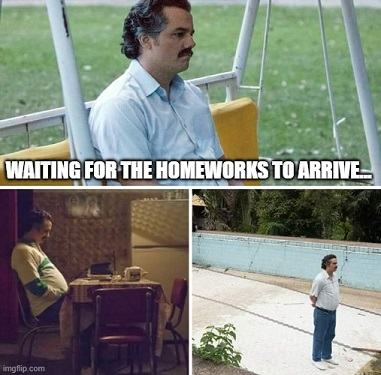